<a href="https://colab.research.google.com/github/JustasBan/bakalauro_notebook/blob/main/bakalauro_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Required ❗

In [ ]:
# set up to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# installs

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import KFold
import os
import threading
import numpy as np
from tqdm import tqdm
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
import cv2

# for paralel training & validation
file_lock = threading.Lock()

# consts

BASE_DIR = "/content/drive/MyDrive/bakis/cross_validation"
BATCH_SIZE = 16
EPOCHS_NUM = 30
NUM_SPLITS = 5
SPLITS = [f'split{i}' for i in range(NUM_SPLITS)]
CATEGORIES = ['covid', 'pneumonia', 'regular']

# Set up POCUS dataset 🔧

In [ ]:
# Data is based in repo
!git clone https://github.com/jannisborn/covid19_ultrasound.git

Cloning into 'covid19_ultrasound'...
remote: Enumerating objects: 4531, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (66/66), done.
^C


In [ ]:
# build dataset
%cd /content/covid19_ultrasound/pocovidnet/scripts/
!python3 build_image_dataset.py -imgs ../../data/pocus_images/ -vids ../../data/pocus_videos/


[Errno 2] No such file or directory: '/content/covid19_ultrasound/pocovidnet/scripts/'
/content
python3: can't open file '/content/build_image_dataset.py': [Errno 2] No such file or directory


In [ ]:
# split to patient-level 5 folds
%cd /content/covid19_ultrasound/pocovidnet
!python3 scripts/cross_val_splitter.py --splits 5 -d ./data/image_dataset/

[Errno 2] No such file or directory: '/content/covid19_ultrasound/pocovidnet'
/content
python3: can't open file '/content/scripts/cross_val_splitter.py': [Errno 2] No such file or directory


In [ ]:
# save

import shutil

source_path = '/content/covid19_ultrasound/data/cross_validation'  # Path to your dataset in Colab
destination_path = '/content/drive/MyDrive/bakis'  # Customize the path in your Drive

shutil.move(source_path, destination_path)

print("Dataset moved to Google Drive successfully!")

# Helpers 🤝

In [ ]:
def create_model():
    base_model = MobileNetV3Large(
        input_shape=(224, 224, 3),
        include_top=False,
        weights=None
    )

    base_model.trainable = True

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    num_classes = 3
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def create_generators(augmentation, dirs, augmentation_type, is_training=True):
    generators = []
    mixup_cutmix_gmix_hmix_used = (augmentation_type in ["mixup", "cutmix", "gmix", "hmix"]) and is_training

    for dir in dirs:
        category_path = os.path.join(BASE_DIR, dir)
        if not os.path.exists(category_path):
            print(f"Warning: The path {category_path} does not exist.")
            continue

        if mixup_cutmix_gmix_hmix_used:
            gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
                category_path,
                target_size=(224, 224),
                batch_size=BATCH_SIZE,
                class_mode='categorical'
            )
            generators.append((gen, len(gen.filenames)))
        else:
            if is_training:
                gen = augmentation.flow_from_directory(
                    category_path,
                    target_size=(224, 224),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical'
                )
            else:
                gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    category_path,
                    target_size=(224, 224),
                    batch_size=BATCH_SIZE,
                    class_mode='categorical'
                )
            generators.append(gen)

    return generators, mixup_cutmix_gmix_hmix_used



def generator_to_dataset(generators):
    def flatten_generator():
        for generator in generators:
            for batch in generator:
                images, labels = batch
                for img, label in zip(images, labels):
                    yield img, label
    return flatten_generator

def prep_data(generators):
    train_data = tf.data.Dataset.from_generator(
        generator_to_dataset(generators),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(3,), dtype=tf.float32)
        )
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_data


In [ ]:
def train_model(augmentation, augmentation_type, fold, model, train_idx):
    # Training directories
    train_dirs = [SPLITS[i] for i in train_idx]

    # Create train generators
    train_generators, mixup_cutmix_gmix_used = create_generators(augmentation, train_dirs, augmentation_type, is_training=True)

    # Calculate steps per epoch
    if mixup_cutmix_gmix_used:
        total_train_images = sum(gen[1] for gen in train_generators)
        train_data = tf.data.Dataset.from_generator(
            generator_to_dataset([gen[0] for gen in train_generators]),
            output_signature=(
                tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(3,), dtype=tf.float32)
            )
        ).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    else:
        total_train_images = sum(gen.samples for gen in train_generators)
        train_data = prep_data(train_generators)

    steps_per_epoch = total_train_images // BATCH_SIZE

    # Train the model
    model.fit(
        train_data,
        epochs=EPOCHS_NUM,
        steps_per_epoch=steps_per_epoch,
    )

    # Save the model for this fold
    with file_lock:
        model_dir = f'/content/drive/MyDrive/bakis/models/model_{augmentation_type}_fold_{fold + 1}'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model.save(model_dir)

    return model


In [ ]:
# model validation

class MetricsCallback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.y_true = []
        self.y_pred = []

    def on_test_batch_end(self, batch, logs=None):
        images, labels = self.val_data.next()
        preds = self.model.predict_on_batch(images)
        self.y_true.extend(np.argmax(labels, axis=1))
        self.y_pred.extend(np.argmax(preds, axis=1))

def validate_model(val_idx, augmentation, model):
    # Validation directories
    val_dirs = [SPLITS[i] for i in val_idx]

    # Create validation generators
    val_generators, _ = create_generators(augmentation, val_dirs, None, is_training=False)

    # Prepare validation data
    val_data = prep_data(val_generators)

    # Calculate steps per validation epoch
    total_val_images = sum(gen.samples for gen in val_generators)
    steps_per_epoch = total_val_images // BATCH_SIZE

    # Create a generator for validation data
    val_data_gen = iter(val_data)

    # Initialize the metrics callback
    metrics_callback = MetricsCallback(val_data_gen)

    # Evaluate the model
    model.evaluate(val_data, steps=steps_per_epoch, callbacks=[metrics_callback], verbose=1)

    y_true = np.array(metrics_callback.y_true)
    y_pred = np.array(metrics_callback.y_pred)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    specificity = []
    for i in range(len(CATEGORIES)):
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        specificity.append(tn / (tn + fp))

    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)

    scores = {
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'balanced_acc': balanced_acc,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'accuracy': accuracy
    }

    return scores


In [ ]:
# gather & save metrics

def process_data(scores, fold, augmentation_type):
    results = {
        "Fold": fold + 1,
        "Accuracy_overall": scores['accuracy'],
        "Balanced Accuracy_overall": scores['balanced_acc'],
        "Macro F1_overall": scores['macro_f1'],
        "Micro F1_overall": scores['micro_f1'],
    }

    for i, category in enumerate(CATEGORIES):
        results[f"{category}_Precision"] = scores['precision'][i]
        results[f"{category}_Recall"] = scores['recall'][i]
        results[f"{category}_Specificity"] = scores['specificity'][i]
        results[f"{category}_F1"] = scores['f1'][i]

    return results

def save_csv(all_results, augmentation_type):
    with file_lock:
        df = pd.DataFrame(all_results)
        RESULTS_PATH = '/content/drive/MyDrive/bakis/results/'
        if not os.path.exists(RESULTS_PATH):
            os.makedirs(RESULTS_PATH)
        df.to_csv(f'{RESULTS_PATH}/{augmentation_type}_results.csv', index=False)

# Augmentations ⚡



### Physics based ✅

In [ ]:
def snr_augmentation(image):
    alpha = np.random.uniform(0.9, 1.8)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=0)

def pressure_distortion(image):
    height, width = image.shape[:2]

    # Randomize pressure strength
    pressure_strength = np.random.uniform(0.1, 0.3)

    # Create displacement map
    y_displacement = np.linspace(pressure_strength * height, 0, height)

    # Create meshgrid of coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply displacement
    y_displaced = y + y_displacement[:, np.newaxis]

    # Calculate x displacement to keep content centered
    x_displacement = (y_displacement[:, np.newaxis] / 2) * (x / width - 0.5)
    x_displaced = x + x_displacement

    # Clip coordinates to image bounds
    y_displaced = np.clip(y_displaced, 0, height - 1)
    x_displaced = np.clip(x_displaced, 0, width - 1)

    # Sample pixel values at displaced coordinates
    coords = np.stack([y_displaced, x_displaced], axis=-1).astype(np.int32)
    transformed_image = image[coords[:, :, 0], coords[:, :, 1]]

    return transformed_image

def add_reverberation(image, intensity_range=(0.1, 0.3), threshold_range=(100, 140)):
    intensity = np.random.uniform(*intensity_range)
    threshold = np.random.randint(*threshold_range)

    if len(image.shape) == 3 and image.shape[2] == 3:  # If image is RGB
        # Convert to grayscale for processing
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    gray_image = gray_image.astype(np.uint8)

    # Threshold to find bright regions
    _, bright_regions = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)

    # Find contours of bright regions
    contours, _ = cv2.findContours(bright_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    reverberated_image = gray_image.copy().astype(float)

    for contour in contours:
        # Create mask for bright region
        mask = np.zeros_like(gray_image)
        cv2.drawContours(mask, [contour], -1, 255, -1)

        # Extract bright region
        bright_patch = cv2.bitwise_and(gray_image, gray_image, mask=mask)

        # Calculate the centroid of the bright region to determine depth
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cY = int(M["m01"] / M["m00"])
        else:
            cY = 0

        # Simulate reverberation by shifting and attenuating the patch
        for i in range(1, 4):  # Add up to 3 reverberation artifacts
            shift = cY * i
            shifted_patch = np.roll(bright_patch, shift, axis=0)
            attenuated_patch = shifted_patch * (intensity ** i)

            # Add attenuated patch to the original image
            reverberated_image += attenuated_patch

    # Normalize the resulting image to the original scale
    reverberated_image = np.clip(reverberated_image, 0, 255).astype(np.uint8)

    # If the original image was color, convert the grayscale result back to a 3-channel image
    if len(image.shape) == 3 and image.shape[2] == 3:
        color_reverberated_image = cv2.cvtColor(reverberated_image, cv2.COLOR_GRAY2BGR)
        return color_reverberated_image

    # Expand dimensions if the image is grayscale for compatibility with ImageDataGenerator
    if len(reverberated_image.shape) == 2:
        reverberated_image = np.expand_dims(reverberated_image, axis=-1)

    return reverberated_image

### mixup, cutmix ✅

In [ ]:
def mixup_augmentation(images, labels, alpha_range=(0.3, 0.6)):
    alpha = np.random.uniform(*alpha_range)
    batch_size = tf.shape(images)[0]

    # Get class indices
    class_indices = [tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])]

    mixed_images = []
    mixed_labels = []
    mix_pairs = []

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        mix_class = possible_classes[i % len(possible_classes)]  # Simple deterministic approach
        mix_idx = class_indices[mix_class][i % len(class_indices[mix_class])].numpy()

        # Define alpha for current image and (1 - alpha) for the mix image
        lam1 = alpha
        lam2 = 1 - alpha
        lam1 = tf.convert_to_tensor(lam1, dtype=tf.float32)
        lam2 = tf.convert_to_tensor(lam2, dtype=tf.float32)
        lam1_x = tf.reshape(lam1, (1, 1, 1, 1))
        lam2_x = tf.reshape(lam2, (1, 1, 1, 1))
        lam1_y = tf.reshape(lam1, (1,))
        lam2_y = tf.reshape(lam2, (1,))

        images_i = tf.cast(images[i], tf.float32)
        labels_i = tf.cast(labels[i], tf.float32)
        images_mix = tf.cast(images[mix_idx], tf.float32)
        labels_mix = tf.cast(labels[mix_idx], tf.float32)

        mixed_image = lam1_x * images_i + lam2_x * images_mix
        mixed_label = lam1_y * labels_i + lam2_y * labels_mix

        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)

        mix_pairs.append((i, mix_idx))

    mixed_images = tf.stack(mixed_images)
    mixed_labels = tf.stack(mixed_labels)

    return mixed_images, mixed_labels, mix_pairs

In [ ]:
def cutmix_augmentation(images, labels, alpha=1.0, min_size=50, max_size=150):
    batch_size = tf.shape(images)[0]

    mixed_images = []
    mixed_labels = []
    masks = []

    # Get class indices
    class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        if not possible_classes or all(class_indices[cls].numpy().size == 0 for cls in possible_classes):
            mixed_images.append(images[i])
            mixed_labels.append(labels[i])
            masks.append(np.zeros((224, 224)))
            continue
        mix_class = np.random.choice([cls for cls in possible_classes if class_indices[cls].numpy().size > 0])
        mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

        lam = tf.convert_to_tensor(np.random.beta(alpha, alpha), dtype=tf.float32)  # Use Beta distribution

        cut_rat = tf.sqrt(1. - lam)
        cut_w = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut width within range
        cut_h = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut height within range

        # Introduce randomness to cut location around the center, but keep it within the image boundaries
        cx = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_w // 2, 224 - cut_w // 2)
        cy = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_h // 2, 224 - cut_h // 2)

        bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, 224)
        bby1 = tf.clip_by_value(cy - cut_h // 2, 0, 224)
        bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, 224)
        bby2 = tf.clip_by_value(cy + cut_h // 2, 0, 224)

        mask = np.zeros((224, 224))
        mask[bby1:bby2, bbx1:bbx2] = 1
        masks.append(mask)

        new_image = images[i].copy()
        new_image[bby1:bby2, bbx1:bbx2, :] = images[mix_idx, bby1:bby2, bbx1:bbx2].copy()

        lam = tf.cast(1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224 * 224)), tf.float32)
        new_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

        mixed_images.append(new_image)
        mixed_labels.append(new_label)

    return np.array(mixed_images), np.array(mixed_labels), np.array(masks)


### gmix, hmix ✅

In [ ]:
def gmix_augmentation(images, labels, alpha_range=(0.2, 0.4), sigma_value=0.3):
    alpha = np.random.uniform(*alpha_range)
    batch_size = tf.shape(images)[0]

    mixed_images = []
    mixed_labels = []
    masks = []

    # Get class indices
    class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        mix_class = np.random.choice(possible_classes)
        mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

        # Use a fixed value for lam
        lam = tf.convert_to_tensor(alpha, dtype=tf.float32)

        center_x = tf.random.uniform(shape=(), minval=0, maxval=224, dtype=tf.float32)
        center_y = tf.random.uniform(shape=(), minval=0, maxval=224, dtype=tf.float32)

        x, y = tf.meshgrid(tf.range(224, dtype=tf.float32), tf.range(224, dtype=tf.float32))
        d = tf.sqrt((x - center_x)**2 + (y - center_y)**2)
        sigma = sigma_value * 224
        mask = tf.exp(-d**2 / (2 * sigma**2))
        mask = tf.expand_dims(mask, axis=-1)

        mixed_image = mask * images[i] + (1 - mask) * images[mix_idx]
        mixed_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)
        masks.append(mask)

    return tf.stack(mixed_images), tf.stack(mixed_labels), tf.stack(masks)


In [ ]:
def hmix_augmentation(images, labels, alpha_mixup=0.4, alpha_cutmix=1.0):
    def mixup_augmentation(images, labels, lam=alpha_mixup):
        batch_size = tf.shape(images)[0]

        # Get class indices
        class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

        mixed_images = []
        mixed_labels = []
        mixup_indices = []

        for i in range(batch_size):
            label_class = tf.argmax(labels[i]).numpy()
            # Select a different class for mixing
            possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
            if not possible_classes:
                mixed_images.append(images[i])
                mixed_labels.append(labels[i])
                mixup_indices.append((i, i))
                continue
            mix_class = np.random.choice(possible_classes)
            if class_indices[mix_class].numpy().size == 0:
                mixed_images.append(images[i])
                mixed_labels.append(labels[i])
                mixup_indices.append((i, i))
                continue
            mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

            lam = tf.convert_to_tensor(np.random.beta(alpha_mixup, alpha_mixup), dtype=tf.float32)  # Weaker mixup

            mixed_image = lam * images[i] + (1 - lam) * images[mix_idx]
            mixed_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

            mixed_images.append(mixed_image)
            mixed_labels.append(mixed_label)
            mixup_indices.append((i, mix_idx))

        return tf.stack(mixed_images), tf.stack(mixed_labels), mixup_indices

    def cutmix_augmentation(images, labels, mixup_indices, alpha=1.5, min_size=20, max_size=150):
        batch_size = tf.shape(images)[0]

        mixed_images = []
        mixed_labels = []
        masks = []
        cutmix_info = []

        for i in range(batch_size):
            orig_idx, mix_idx = mixup_indices[i]

            lam = tf.convert_to_tensor(np.random.beta(alpha, alpha), dtype=tf.float32)  # Stronger cutmix

            cut_rat = tf.sqrt(1. - lam)
            cut_w = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut width within range
            cut_h = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut height within range

            # Introduce randomness to cut location around the center, but keep it within the image boundaries
            cx = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_w // 2, 224 - cut_w // 2)
            cy = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_h // 2, 224 - cut_h // 2)

            bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, 224)
            bby1 = tf.clip_by_value(cy - cut_h // 2, 0, 224)
            bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, 224)
            bby2 = tf.clip_by_value(cy + cut_h // 2, 0, 224)

            mask = np.zeros((224, 224))
            mask[bby1:bby2, bbx1:bbx2] = 1
            masks.append(mask)

            new_image = images[orig_idx].numpy()
            new_image[bby1:bby2, bbx1:bbx2, :] = images[mix_idx, bby1:bby2, bbx1:bbx2, :].numpy()

            lam = tf.cast(1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224 * 224)), tf.float32)
            new_label = lam * labels[orig_idx] + (1 - lam) * labels[mix_idx]

            mixed_images.append(new_image)
            mixed_labels.append(new_label)
            cutmix_info.append((tf.argmax(labels[orig_idx]).numpy(), tf.argmax(labels[mix_idx]).numpy()))

        return tf.convert_to_tensor(mixed_images), tf.convert_to_tensor(mixed_labels), tf.convert_to_tensor(masks), cutmix_info

    # Apply MixUp with weaker effect
    mixup_images, mixup_labels, mixup_indices = mixup_augmentation(images, labels, lam=0.5)

    # Apply CutMix on the MixUp result with stronger effect
    cutmix_images, cutmix_labels, masks, cutmix_info = cutmix_augmentation(mixup_images, mixup_labels, mixup_indices)

    return cutmix_images, cutmix_labels, masks, mixup_indices, cutmix_info


## Factory 🏭

In [ ]:
class AugmentationFactory:
    @staticmethod
    def get_augmentation(augmentation_type, **kwargs):
        if augmentation_type == None:
            return ImageDataGenerator(rescale=1./255)

        elif augmentation_type == "deformation":
            return ImageDataGenerator(
                preprocessing_function=pressure_distortion
            )

        elif augmentation_type == "reverberation":
            return ImageDataGenerator(
                preprocessing_function=add_reverberation
            )

        elif augmentation_type == "snr":
            return ImageDataGenerator(
                preprocessing_function=snr_augmentation
            )

        elif augmentation_type == "mixup":
            def mixup_generator(gen):
                for images, labels in gen:
                    yield mixup_augmentation(images, labels)

            return mixup_generator

        elif augmentation_type == "cutmix":
            def cutmix_generator(gen):
                for images, labels in gen:
                    yield cutmix_augmentation(images, labels)

            return cutmix_generator

        elif augmentation_type == "gmix":
            def gmix_generator(gen):
                for images, labels in gen:
                    yield gmix_augmentation(images, labels)

            return gmix_generator

        elif augmentation_type == "hmix":
            def hmix_generator(gen):
                for images, labels in gen:
                    yield hmix_augmentation(images, labels)

            return hmix_generator

        elif augmentation_type == "affine":
            return ImageDataGenerator(
                horizontal_flip=True,
                vertical_flip=True,
                zoom_range=[0.8, 1.2],
                rotation_range=360
            )

        else:
            raise ValueError(f"Unknown augmentation type: {augmentation_type}")


# Examples 📷

## Debug 🖥

In [ ]:
image_paths = [
    '/content/drive/MyDrive/bakis/cross_validation/split1/covid/Cov-Atlas-Day+4.gif_frame24.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split1/pneumonia/Pneu_from_article_rippey.mp4_frame35.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split0/regular/Reg_Avi_Image003.mp4_frame64.jpg'
]

Image 1 mixup: (covid, regular), cutmix: (covid, regular)
Image 2 mixup: (pneumonia, regular), cutmix: (pneumonia, regular)
Image 3 mixup: (regular, pneumonia), cutmix: (regular, pneumonia)
Image 4 mixup: (covid, pneumonia), cutmix: (covid, pneumonia)
Image 5 mixup: (pneumonia, regular), cutmix: (pneumonia, regular)
Image 6 mixup: (regular, covid), cutmix: (regular, covid)


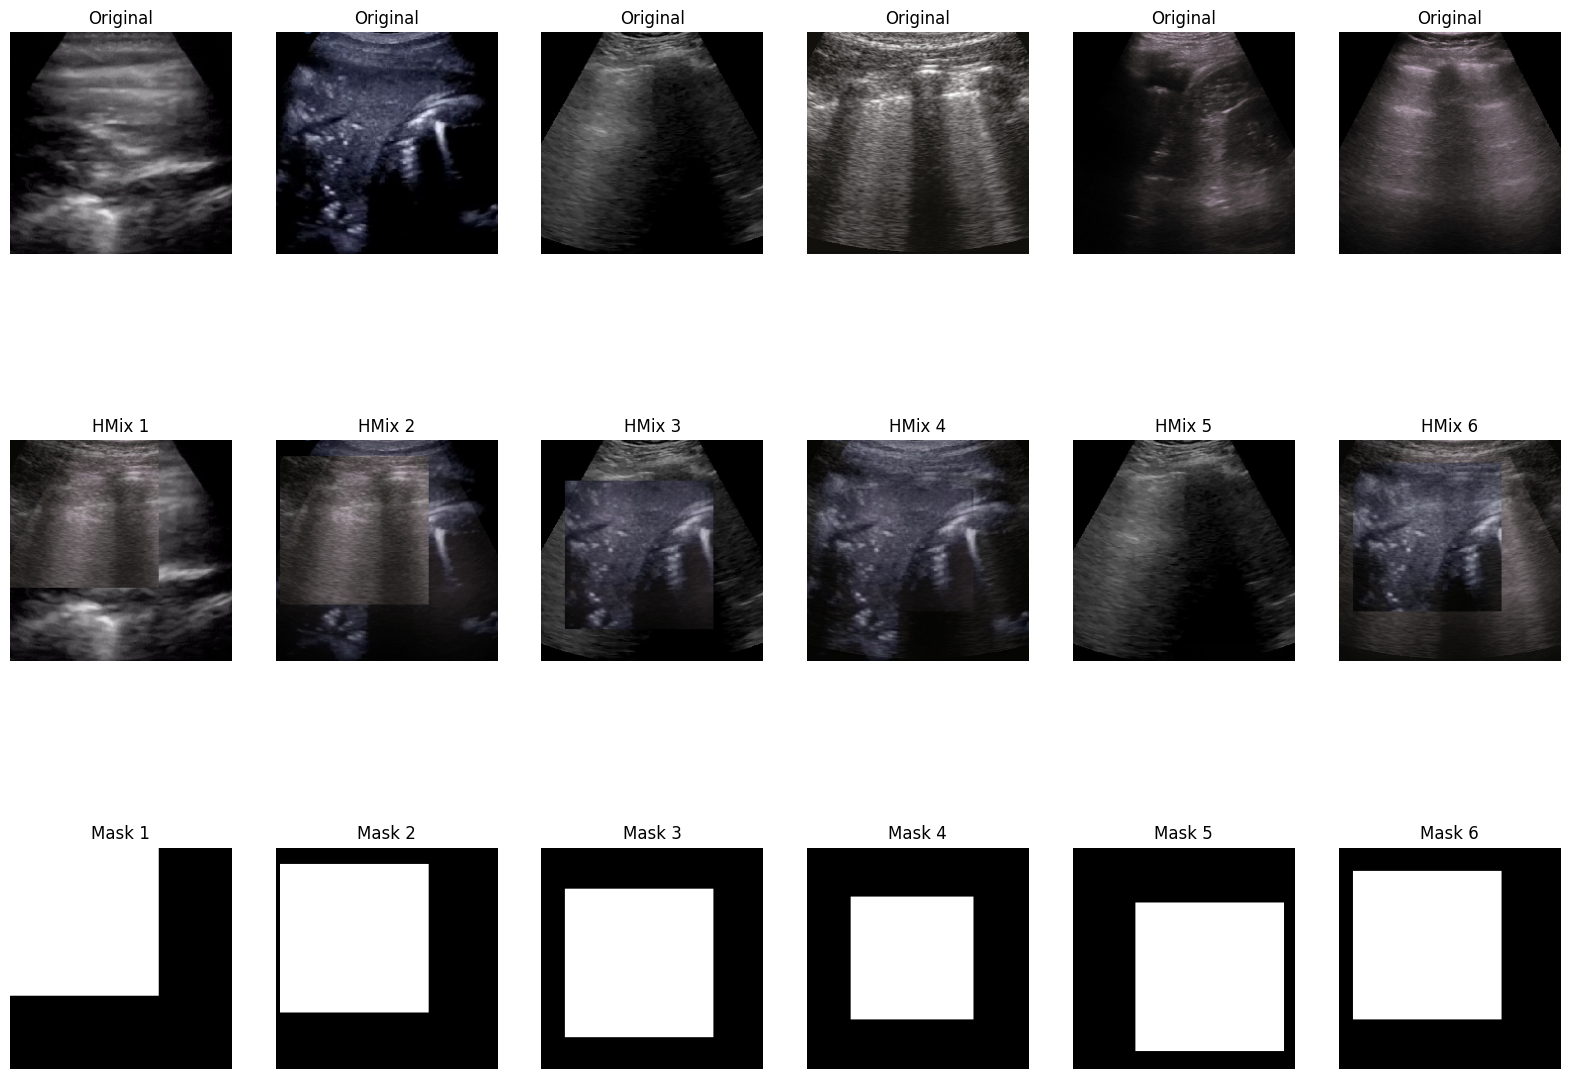

In [ ]:
def apply_and_display_hmix(image_paths):
    # Load the images and their labels
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        images.append(image_array)

        # Dummy labels for demonstration purposes
        label = np.zeros((3,))
        if "covid" in image_path:
            label[0] = 1
        elif "pneumonia" in image_path:
            label[1] = 1
        else:
            label[2] = 1
        labels.append(label)

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    # Apply HMix augmentation
    hmix_images, hmix_labels, masks, mixup_indices, cutmix_info = hmix_augmentation(images, labels)

    # Print mixup and cutmix information
    class_names = ['covid', 'pneumonia', 'regular']
    for i in range(len(image_paths)):
        orig_class = class_names[tf.argmax(labels[mixup_indices[i][0]]).numpy()]
        mix_class = class_names[tf.argmax(labels[mixup_indices[i][1]]).numpy()]
        print(f"Image {i + 1} mixup: ({orig_class}, {mix_class}), cutmix: ({orig_class}, {mix_class})")

    # Plot the original, augmented images, and masks
    plt.figure(figsize=(20, 15))
    for i in range(len(image_paths)):
        # Original image
        plt.subplot(3, len(image_paths), i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title("Original")
        plt.axis('off')

        # Augmented image
        plt.subplot(3, len(image_paths), i + 1 + len(image_paths))
        plt.imshow(hmix_images[i].numpy().astype('uint8'))
        plt.title(f"HMix {i + 1}")
        plt.axis('off')

        # CutMix mask
        plt.subplot(3, len(image_paths), i + 1 + 2 * len(image_paths))
        plt.imshow(masks[i].numpy(), cmap='gray')
        plt.title(f"Mask {i + 1}")
        plt.axis('off')

    plt.show()

apply_and_display_hmix(image_paths)


Image 0 (class 0) is mixed with Image [1] (class 1)
Image 1 (class 1) is mixed with Image [5] (class 2)
Image 2 (class 2) is mixed with Image [0] (class 0)
Image 3 (class 0) is mixed with Image [5] (class 2)
Image 4 (class 1) is mixed with Image [0] (class 0)
Image 5 (class 2) is mixed with Image [4] (class 1)


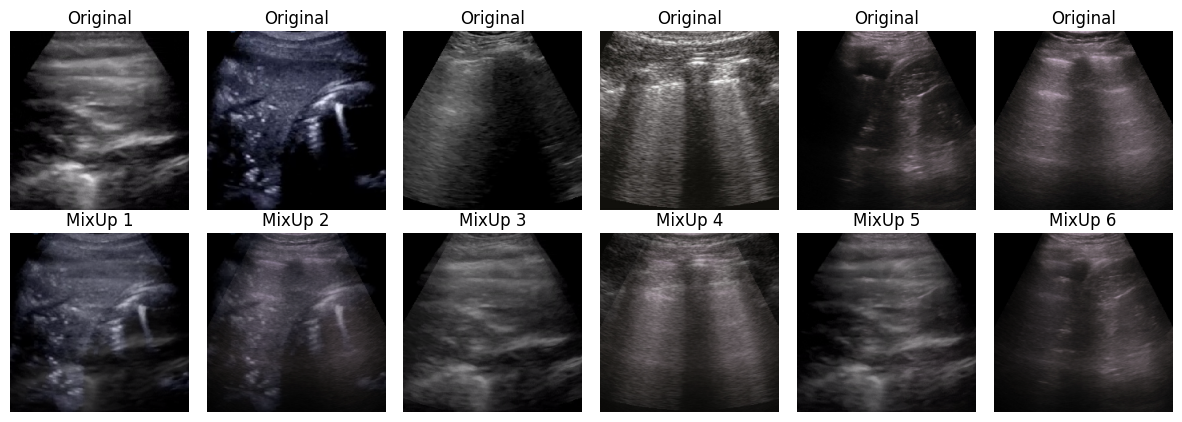

In [ ]:
def apply_and_display_mixup(image_paths):
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        images.append(image_array)

        # Dummy labels for demonstration purposes
        label = np.zeros((3,))
        if "covid" in image_path:
            label[0] = 1
        elif "pneumonia" in image_path:
            label[1] = 1
        else:
            label[2] = 1
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    # Apply MixUp augmentation
    mixup_images, mixup_labels, mix_pairs = mixup_augmentation(images, labels)

    # Print out the pairs being mixed
    for orig_idx, mix_idx in mix_pairs:
        print(f"Image {orig_idx} (class {np.argmax(labels[orig_idx])}) is mixed with Image {mix_idx} (class {np.argmax(labels[mix_idx])})")

    # Plot the original and augmented images
    plt.figure(figsize=(15, 5))
    for i in range(len(image_paths)):
        # Original image
        plt.subplot(2, len(image_paths), i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title("Original")
        plt.axis('off')

        # Augmented image
        plt.subplot(2, len(image_paths), i + 1 + len(image_paths))
        plt.imshow(tf.squeeze(mixup_images[i]).numpy().astype('uint8'))
        plt.title(f"MixUp {i + 1}")
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Example usage
image_paths = [
    '/content/drive/MyDrive/bakis/cross_validation/split1/covid/Cov-Atlas-Day+4.gif_frame24.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split1/pneumonia/Pneu_from_article_rippey.mp4_frame35.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split0/regular/Reg_Avi_Image003.mp4_frame64.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split4/covid/Cov_Oliviera_2020_Fig5A.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split4/pneumonia/Pneu_Avi_small-effusionA-line.JPG',
    '/content/drive/MyDrive/bakis/cross_validation/split4/regular/Reg_Avi_normal-A-lines-pleural-line.JPG'
]

apply_and_display_mixup(image_paths)

## Thesis 📑

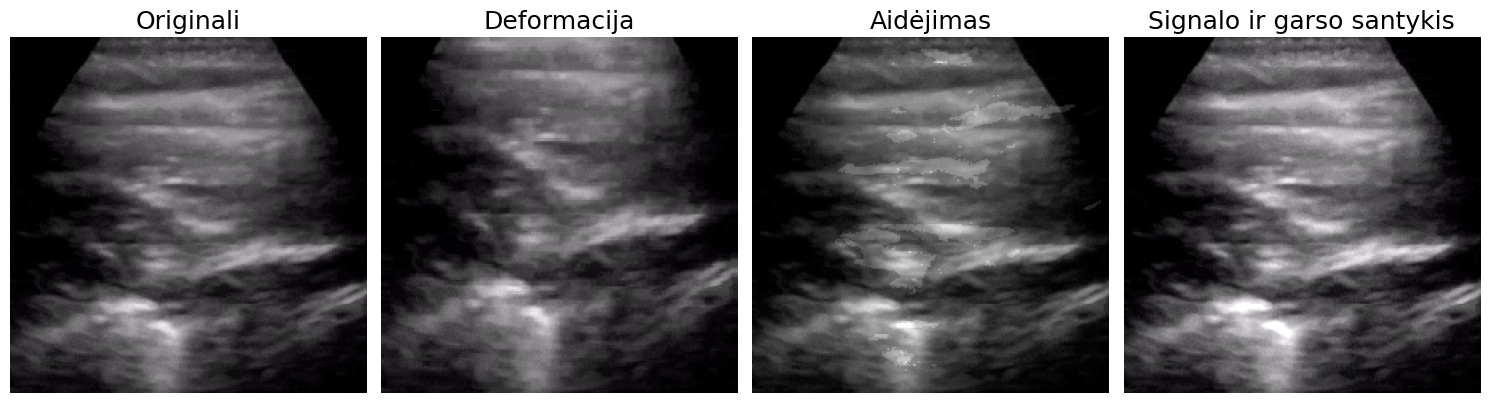

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2

# Load the image
def load_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    return img_to_array(image).astype('uint8')

# Apply augmentations
def apply_augmentations(image):
    augmentations = {
        "Originali": image,
        "Deformacija": pressure_distortion(image),
        "Aidėjimas": add_reverberation(image),
        "Signalo ir garso santykis": snr_augmentation(image)
    }
    return augmentations

# Display the augmentations
def display_augmentations(augmentations):
    plt.figure(figsize=(15, 10))
    for i, (title, aug_image) in enumerate(augmentations.items(), 1):
        if isinstance(aug_image, tuple):
            aug_image = aug_image[0]  # Extract image if it's returned as a tuple
        plt.subplot(1, len(augmentations), i)
        plt.imshow(aug_image.astype('uint8'))
        plt.title(title, fontsize=18)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main function to load, apply and display augmentations
def showcase_augmentations(image_path):
    image = load_image(image_path)
    augmentations = apply_augmentations(image)
    display_augmentations(augmentations)

# Example usage
image_path = '/content/drive/MyDrive/bakis/cross_validation/split1/covid/Cov-Atlas-Day+4.gif_frame24.jpg'
showcase_augmentations(image_path)


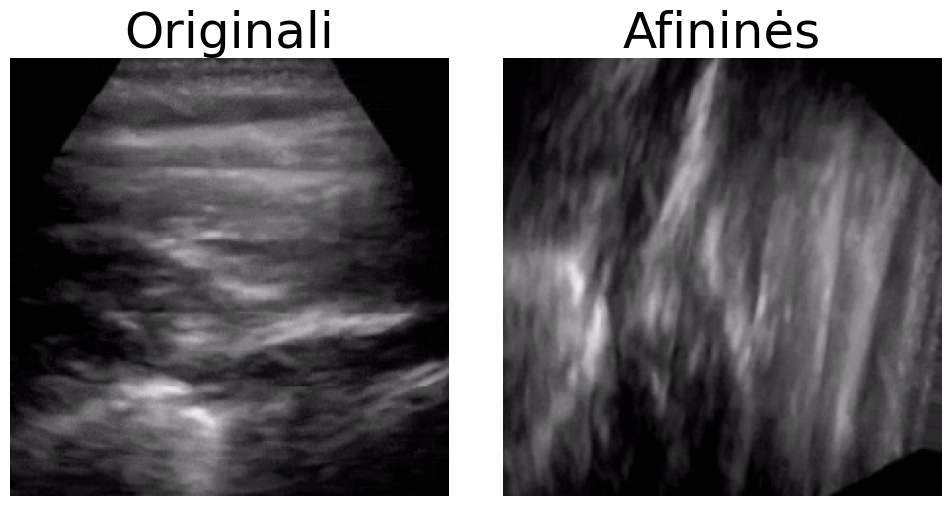

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the image
def load_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    return img_to_array(image).astype('uint8')

# Apply affine augmentation
def apply_affine_augmentation(image):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=360
    )
    image = np.expand_dims(image, 0)  # Add batch dimension
    it = datagen.flow(image, batch_size=1)
    augmented_image = it.next()[0].astype('uint8')  # Get the augmented image
    return augmented_image

# Display the original and augmented images
def display_affine_augmentation(image_path):
    original_image = load_image(image_path)
    augmented_image = apply_affine_augmentation(original_image)

    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.astype('uint8'))
    plt.title("Originali", fontsize=36)
    plt.axis('off')

    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Afininės", fontsize=36)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/bakis/cross_validation/split1/covid/Cov-Atlas-Day+4.gif_frame24.jpg'
display_affine_augmentation(image_path)


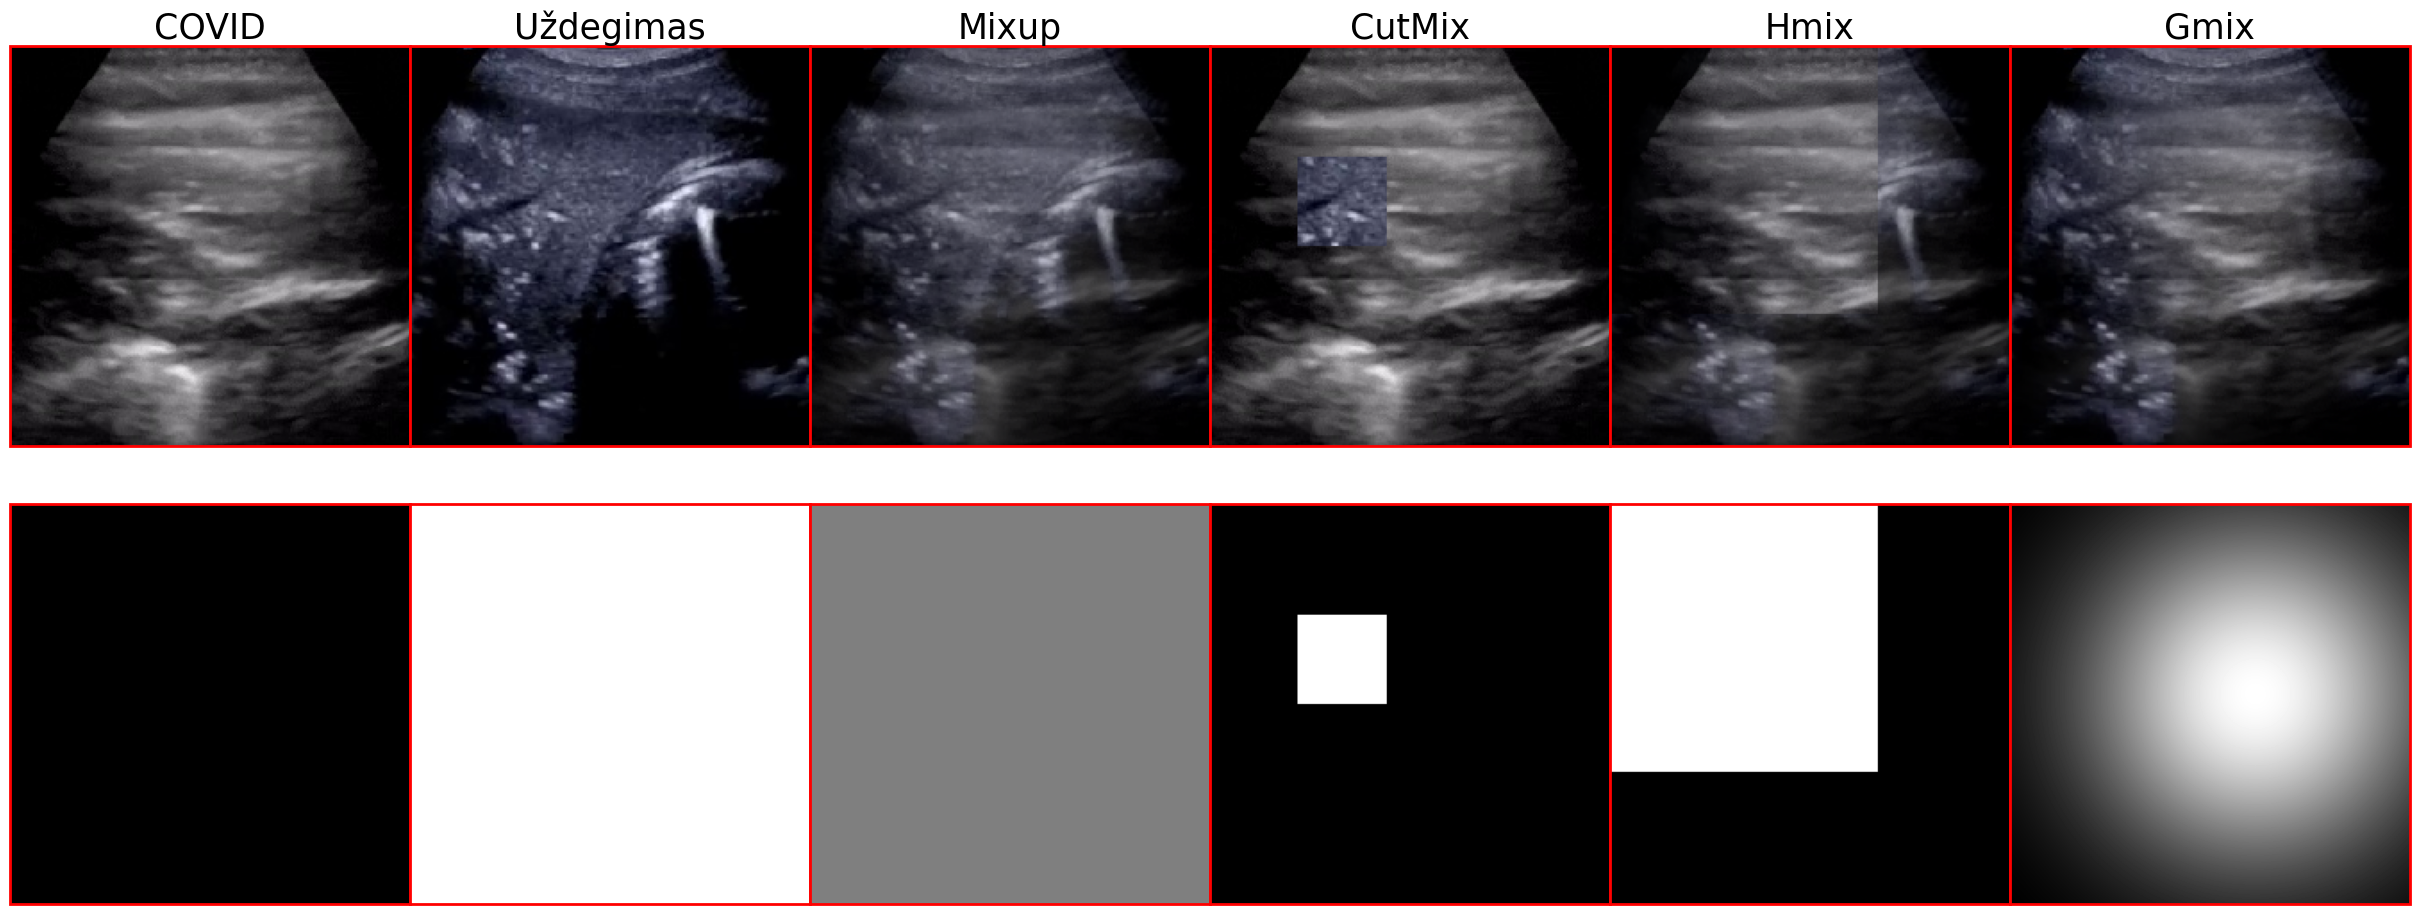

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import tensorflow as tf

# Function to add a border around each subplot
def add_border(ax, color='red', linewidth=2):
    rect = Rectangle((0, 0), 1, 1, fill=False, edgecolor=color, linewidth=linewidth, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)

def load_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    return img_to_array(image).astype('uint8')

def mixup_augmentation(images, labels, alpha_range=(0.3, 0.6)):
    alpha = np.random.uniform(*alpha_range)
    batch_size = tf.shape(images)[0]

    # Get class indices
    class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

    mixed_images = []
    mixed_labels = []
    mix_pairs = []

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        possible_classes = [cls for cls in possible_classes if len(class_indices[cls]) > 0]

        if not possible_classes:
            mixed_images.append(images[i])
            mixed_labels.append(labels[i])
            mix_pairs.append((i, i))
            continue

        mix_class = np.random.choice(possible_classes)
        mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

        # Define alpha for current image and (1 - alpha) for the mix image
        lam1 = alpha
        lam2 = 1 - alpha
        lam1 = tf.convert_to_tensor(lam1, dtype=tf.float32)
        lam2 = tf.convert_to_tensor(lam2, dtype=tf.float32)
        lam1_x = tf.reshape(lam1, (1, 1, 1, 1))
        lam2_x = tf.reshape(lam2, (1, 1, 1, 1))
        lam1_y = tf.reshape(lam1, (1,))
        lam2_y = tf.reshape(lam2, (1,))

        images_i = tf.cast(images[i], tf.float32)
        labels_i = tf.cast(labels[i], tf.float32)
        images_mix = tf.cast(images[mix_idx], tf.float32)
        labels_mix = tf.cast(labels[mix_idx], tf.float32)

        mixed_image = lam1_x * images_i + lam2_x * images_mix
        mixed_label = lam1_y * labels_i + lam2_y * labels_mix

        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)

        mix_pairs.append((i, mix_idx))

    mixed_images = tf.stack(mixed_images)
    mixed_labels = tf.stack(mixed_labels)

    return mixed_images, mixed_labels, mix_pairs

def cutmix_augmentation(images, labels, alpha=1.0, min_size=50, max_size=150):
    batch_size = tf.shape(images)[0]

    mixed_images = []
    mixed_labels = []
    masks = []

    # Get class indices
    class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        if not possible_classes or all(class_indices[cls].numpy().size == 0 for cls in possible_classes):
            mixed_images.append(images[i])
            mixed_labels.append(labels[i])
            masks.append(np.zeros((224, 224)))
            continue
        mix_class = np.random.choice([cls for cls in possible_classes if class_indices[cls].numpy().size > 0])
        mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

        lam = tf.convert_to_tensor(np.random.beta(alpha, alpha), dtype=tf.float32)  # Use Beta distribution

        cut_rat = tf.sqrt(1. - lam)
        cut_w = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut width within range
        cut_h = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut height within range

        # Introduce randomness to cut location around the center, but keep it within the image boundaries
        cx = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_w // 2, 224 - cut_w // 2)
        cy = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_h // 2, 224 - cut_h // 2)

        bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, 224)
        bby1 = tf.clip_by_value(cy - cut_h // 2, 0, 224)
        bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, 224)
        bby2 = tf.clip_by_value(cy + cut_h // 2, 0, 224)

        mask = np.zeros((224, 224))
        mask[bby1:bby2, bbx1:bbx2] = 1
        masks.append(mask)

        new_image = images[i].copy()
        new_image[bby1:bby2, bbx1:bbx2, :] = images[mix_idx, bby1:bby2, bbx1:bbx2].copy()

        lam = tf.cast(1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224 * 224)), tf.float32)
        new_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

        mixed_images.append(new_image)
        mixed_labels.append(new_label)

    return np.array(mixed_images), np.array(mixed_labels), np.array(masks)

def gmix_augmentation(images, labels, alpha_range=(0.2, 0.4), sigma_value=0.3):
    alpha = np.random.uniform(*alpha_range)
    batch_size = tf.shape(images)[0]

    mixed_images = []
    mixed_labels = []
    masks = []

    # Get class indices
    class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

    for i in range(batch_size):
        label_class = tf.argmax(labels[i]).numpy()
        # Select a different class for mixing
        possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
        possible_classes = [cls for cls in possible_classes if len(class_indices[cls]) > 0]

        if not possible_classes:
            mixed_images.append(images[i])
            mixed_labels.append(labels[i])
            masks.append(np.zeros((224, 224, 1)))
            continue

        mix_class = np.random.choice(possible_classes)
        mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

        # Use a fixed value for lam
        lam = tf.convert_to_tensor(alpha, dtype=tf.float32)

        center_x = tf.random.uniform(shape=(), minval=0, maxval=224, dtype=tf.float32)
        center_y = tf.random.uniform(shape=(), minval=0, maxval=224, dtype=tf.float32)

        x, y = tf.meshgrid(tf.range(224, dtype=tf.float32), tf.range(224, dtype=tf.float32))
        d = tf.sqrt((x - center_x)**2 + (y - center_y)**2)
        sigma = sigma_value * 224
        mask = tf.exp(-d**2 / (2 * sigma**2))
        mask = tf.expand_dims(mask, axis=-1)

        mixed_image = mask * images[i] + (1 - mask) * images[mix_idx]
        mixed_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

        mixed_images.append(mixed_image)
        mixed_labels.append(mixed_label)
        masks.append(mask)

    return tf.stack(mixed_images), tf.stack(mixed_labels), tf.stack(masks)

def hmix_augmentation(images, labels, alpha_mixup=0.4, alpha_cutmix=1.0):
    def mixup_augmentation(images, labels, lam=alpha_mixup):
        batch_size = tf.shape(images)[0]

        # Get class indices
        class_indices = {i: tf.where(tf.argmax(labels, axis=1) == i) for i in range(labels.shape[1])}

        mixed_images = []
        mixed_labels = []
        mixup_indices = []

        for i in range(batch_size):
            label_class = tf.argmax(labels[i]).numpy()
            # Select a different class for mixing
            possible_classes = [cls for cls in range(labels.shape[1]) if cls != label_class]
            if not possible_classes:
                mixed_images.append(images[i])
                mixed_labels.append(labels[i])
                mixup_indices.append((i, i))
                continue
            mix_class = np.random.choice(possible_classes)
            if class_indices[mix_class].numpy().size == 0:
                mixed_images.append(images[i])
                mixed_labels.append(labels[i])
                mixup_indices.append((i, i))
                continue
            mix_idx = np.random.choice(class_indices[mix_class].numpy().flatten())

            lam = tf.convert_to_tensor(np.random.beta(alpha_mixup, alpha_mixup), dtype=tf.float32)  # Weaker mixup

            mixed_image = lam * images[i] + (1 - lam) * images[mix_idx]
            mixed_label = lam * labels[i] + (1 - lam) * labels[mix_idx]

            mixed_images.append(mixed_image)
            mixed_labels.append(mixed_label)
            mixup_indices.append((i, mix_idx))

        return tf.stack(mixed_images), tf.stack(mixed_labels), mixup_indices

    def cutmix_augmentation(images, labels, mixup_indices, alpha=1.5, min_size=20, max_size=150):
        batch_size = tf.shape(images)[0]

        mixed_images = []
        mixed_labels = []
        masks = []
        cutmix_info = []

        for i in range(batch_size):
            orig_idx, mix_idx = mixup_indices[i]

            lam = tf.convert_to_tensor(np.random.beta(alpha, alpha), dtype=tf.float32)  # Stronger cutmix

            cut_rat = tf.sqrt(1. - lam)
            cut_w = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut width within range
            cut_h = tf.clip_by_value(tf.cast(224 * cut_rat, tf.int32), min_size, max_size)  # Ensure cut height within range

            # Introduce randomness to cut location around the center, but keep it within the image boundaries
            cx = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_w // 2, 224 - cut_w // 2)
            cy = tf.clip_by_value(112 + tf.random.uniform(shape=(), minval=-50, maxval=50, dtype=tf.int32), cut_h // 2, 224 - cut_h // 2)

            bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, 224)
            bby1 = tf.clip_by_value(cy - cut_h // 2, 0, 224)
            bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, 224)
            bby2 = tf.clip_by_value(cy + cut_h // 2, 0, 224)

            mask = np.zeros((224, 224))
            mask[bby1:bby2, bbx1:bbx2] = 1
            masks.append(mask)

            new_image = images[orig_idx].numpy()
            new_image[bby1:bby2, bbx1:bbx2, :] = images[mix_idx, bby1:bby2, bbx1:bbx2, :].numpy()

            lam = tf.cast(1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224 * 224)), tf.float32)
            new_label = lam * labels[orig_idx] + (1 - lam) * labels[mix_idx]

            mixed_images.append(new_image)
            mixed_labels.append(new_label)
            cutmix_info.append((tf.argmax(labels[orig_idx]).numpy(), tf.argmax(labels[mix_idx]).numpy()))

        return tf.convert_to_tensor(mixed_images), tf.convert_to_tensor(mixed_labels), tf.convert_to_tensor(masks), cutmix_info

    # Apply MixUp with weaker effect
    mixup_images, mixup_labels, mixup_indices = mixup_augmentation(images, labels, lam=0.5)

    # Apply CutMix on the MixUp result with stronger effect
    cutmix_images, cutmix_labels, masks, cutmix_info = cutmix_augmentation(mixup_images, mixup_labels, mixup_indices)

    return cutmix_images, cutmix_labels, masks, mixup_indices, cutmix_info

def display_augmentations(image_paths):
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        images.append(image_array)

        # Dummy labels for demonstration purposes
        label = np.zeros((3,))
        if "covid" in image_path:
            label[0] = 1
        elif "pneumonia" in image_path:
            label[1] = 1
        else:
            label[2] = 1
        labels.append(label)

    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    # Apply Mixup augmentation
    mixup_images, mixup_labels, _ = mixup_augmentation(images, labels)

    # Apply CutMix augmentation
    cutmix_images, cutmix_labels, cutmix_masks = cutmix_augmentation(images, labels)

    # Apply Gmix augmentation
    gmix_images, gmix_labels, gmix_masks = gmix_augmentation(images, labels)

    # Apply Hmix augmentation
    hmix_images, hmix_labels, hmix_masks, _, _ = hmix_augmentation(images, labels)

    # Create masks for the first two original images
    black_mask = np.zeros((224, 224, 3), dtype=np.uint8)
    white_mask = np.ones((224, 224, 3), dtype=np.uint8) * 255
    grey_mask = np.ones((224, 224, 3), dtype=np.uint8) * 127  # Average of black and white masks

    # Plot the original and augmented images along with masks
    fig, axs = plt.subplots(2, 6, figsize=(24, 10))  # Adjusted to 6 columns per row and increased height

    # First row: Original and augmented images
    axs[0, 0].imshow(images[0].astype('uint8'))
    axs[0, 0].set_title("COVID", fontsize=25)
    axs[0, 0].axis('off')
    add_border(axs[0, 0])

    axs[0, 1].imshow(images[1].astype('uint8'))
    axs[0, 1].set_title("Uždegimas", fontsize=25)
    axs[0, 1].axis('off')
    add_border(axs[0, 1])

    axs[0, 2].imshow(np.squeeze(mixup_images[0].numpy().astype('uint8')))
    axs[0, 2].set_title("Mixup", fontsize=25)
    axs[0, 2].axis('off')
    add_border(axs[0, 2])

    axs[0, 3].imshow(np.squeeze(cutmix_images[0].astype('uint8')))
    axs[0, 3].set_title("CutMix", fontsize=25)
    axs[0, 3].axis('off')
    add_border(axs[0, 3])

    axs[0, 4].imshow(np.squeeze(hmix_images[0].numpy().astype('uint8')))
    axs[0, 4].set_title("Hmix", fontsize=25)
    axs[0, 4].axis('off')
    add_border(axs[0, 4])

    axs[0, 5].imshow(np.squeeze(gmix_images[0].numpy().astype('uint8')))
    axs[0, 5].set_title("Gmix", fontsize=25)
    axs[0, 5].axis('off')
    add_border(axs[0, 5])

    # Second row: Masks
    axs[1, 0].imshow(black_mask)
    axs[1, 0].axis('off')
    add_border(axs[1, 0])

    axs[1, 1].imshow(white_mask)
    axs[1, 1].axis('off')
    add_border(axs[1, 1])

    axs[1, 2].imshow(grey_mask)
    axs[1, 2].axis('off')
    add_border(axs[1, 2])

    axs[1, 3].imshow(np.squeeze(cutmix_masks[0]), cmap='gray')
    axs[1, 3].axis('off')
    add_border(axs[1, 3])

    axs[1, 4].imshow(np.squeeze(hmix_masks[0].numpy()), cmap='gray')
    axs[1, 4].axis('off')
    add_border(axs[1, 4])

    axs[1, 5].imshow(np.squeeze(gmix_masks[0].numpy()), cmap='gray')
    axs[1, 5].axis('off')
    add_border(axs[1, 5])

    plt.tight_layout(pad=0)  # Increased padding between plots
    plt.show()

# Example usage
image_paths = [
    '/content/drive/MyDrive/bakis/cross_validation/split1/covid/Cov-Atlas-Day+4.gif_frame24.jpg',
    '/content/drive/MyDrive/bakis/cross_validation/split1/pneumonia/Pneu_from_article_rippey.mp4_frame35.jpg'
]

display_augmentations(image_paths)


# Training 🏃

In [ ]:
def cross_evaluate_model(augmentation_type):
    print(f"Running cross-validation with {augmentation_type} augmentation...")

    augmentation = AugmentationFactory.get_augmentation(augmentation_type)
    kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=42)

    results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(SPLITS)):
        print(f"Training fold {fold + 1} with {augmentation_type} augmentation...")
        fresh_model = create_model()
        trained_model = train_model(augmentation, augmentation_type, fold, fresh_model, train_idx)

        print(f"Validating fold {fold + 1} with {augmentation_type} augmentation:")
        scores = validate_model(val_idx, augmentation, trained_model)

        metrics = process_data(scores, fold, augmentation_type)
        results.append(metrics)

    save_csv(results, augmentation_type)


In [ ]:
cross_evaluate_model("hmix")

Running cross-validation with hmix augmentation...
Training fold 1 with hmix augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 29s 60ms/step - loss: 0.3193 - accuracy: 0.8825
Epoch 2/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0983 - accuracy: 0.9663
Epoch 3/30
117/117 [==============================] - 7s 58ms/step - loss: 0.1014 - accuracy: 0.9658
Epoch 4/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0166 - accuracy: 0.9968
Epoch 5/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0120 - accuracy: 0.9973
Epoch 6/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0067 - accuracy: 0.9979
Epoch 7/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0519 - accuracy: 0.9861
Epoch 8/30
117/117 [===============

25/25 [==============================] - 83s 3s/step - loss: 2.8986 - accuracy: 0.5700
Training fold 2 with hmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 30s 60ms/step - loss: 0.2856 - accuracy: 0.8854
Epoch 2/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0963 - accuracy: 0.9711
Epoch 3/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0631 - accuracy: 0.9803
Epoch 4/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0226 - accuracy: 0.9948
Epoch 5/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0607 - accuracy: 0.9867
Epoch 6/30
108/108 [==============================] - 6s 59ms/step - loss: 0.0526 - accuracy: 0.9850
Epoch 7/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0363 - accuracy: 0.9867

34/34 [==============================] - 96s 2s/step - loss: 1.8759 - accuracy: 0.7243
Training fold 3 with hmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 30s 61ms/step - loss: 0.3640 - accuracy: 0.8605
Epoch 2/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0806 - accuracy: 0.9720
Epoch 3/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0553 - accuracy: 0.9887
Epoch 4/30
116/116 [==============================] - 7s 62ms/step - loss: 0.0308 - accuracy: 0.9908
Epoch 5/30
116/116 [==============================] - 7s 64ms/step - loss: 0.0056 - accuracy: 0.9978
Epoch 6/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0247 - accuracy: 0.9941
Epoch 7/30
116/116 [==============================] - 7s 61ms/step - loss: 0.1041 - accuracy: 0.9741

26/26 [==============================] - 139s 4s/step - loss: 2.8041 - accuracy: 0.6707
Training fold 4 with hmix augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 30s 61ms/step - loss: 0.3377 - accuracy: 0.8782
Epoch 2/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0693 - accuracy: 0.9725
Epoch 3/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0776 - accuracy: 0.9746
Epoch 4/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0757 - accuracy: 0.9793
Epoch 5/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0210 - accuracy: 0.9942
Epoch 6/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0252 - accuracy: 0.9915
Epoch 7/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0575 - accuracy: 0.982

24/24 [==============================] - 5s 85ms/step - loss: 2.4799 - accuracy: 0.5859
Training fold 5 with hmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 30s 62ms/step - loss: 0.4086 - accuracy: 0.8452
Epoch 2/30
111/111 [==============================] - 7s 61ms/step - loss: 0.1012 - accuracy: 0.9696
Epoch 3/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0579 - accuracy: 0.9814
Epoch 4/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0585 - accuracy: 0.9803
Epoch 5/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0726 - accuracy: 0.9702
Epoch 6/30
111/111 [==============================] - 7s 59ms/step - loss: 0.0095 - accuracy: 0.9989
Epoch 7/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0022 - accuracy: 0.999

31/31 [==============================] - 185s 5s/step - loss: 2.6135 - accuracy: 0.6129


In [ ]:
cross_evaluate_model("gmix")

Running cross-validation with gmix augmentation...
Training fold 1 with gmix augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 32s 61ms/step - loss: 0.2779 - accuracy: 0.9006
Epoch 2/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0708 - accuracy: 0.9776
Epoch 3/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0572 - accuracy: 0.9829
Epoch 4/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0186 - accuracy: 0.9925
Epoch 5/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0109 - accuracy: 0.9957
Epoch 6/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 7/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0570 - accuracy: 0.9856
Epoch 8/30
117/117 [===============

25/25 [==============================] - 5s 80ms/step - loss: 3.7188 - accuracy: 0.5850
Training fold 2 with gmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 29s 61ms/step - loss: 0.2369 - accuracy: 0.9057
Epoch 2/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0813 - accuracy: 0.9734
Epoch 3/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0736 - accuracy: 0.9740
Epoch 4/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0103 - accuracy: 0.9965
Epoch 5/30
108/108 [==============================] - 6s 59ms/step - loss: 0.0501 - accuracy: 0.9838
Epoch 6/30
108/108 [==============================] - 7s 62ms/step - loss: 0.0192 - accuracy: 0.9954
Epoch 7/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0014 - accuracy: 1.000

34/34 [==============================] - 6s 82ms/step - loss: 1.6327 - accuracy: 0.7831
Training fold 3 with gmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 30s 61ms/step - loss: 0.2705 - accuracy: 0.8987
Epoch 2/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0669 - accuracy: 0.9795
Epoch 3/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0710 - accuracy: 0.9768
Epoch 4/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0202 - accuracy: 0.9919
Epoch 5/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0347 - accuracy: 0.9887
Epoch 6/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0015 - accuracy: 1.000

26/26 [==============================] - 5s 90ms/step - loss: 2.9504 - accuracy: 0.6875
Training fold 4 with gmix augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 30s 61ms/step - loss: 0.2693 - accuracy: 0.9073
Epoch 2/30
118/118 [==============================] - 8s 64ms/step - loss: 0.0721 - accuracy: 0.9772
Epoch 3/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0835 - accuracy: 0.9762
Epoch 4/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0549 - accuracy: 0.9767
Epoch 5/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0467 - accuracy: 0.9868
Epoch 6/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 7/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0029 - accuracy: 0.998

24/24 [==============================] - 5s 81ms/step - loss: 3.3261 - accuracy: 0.5339
Training fold 5 with gmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 31s 59ms/step - loss: 0.3414 - accuracy: 0.8761
Epoch 2/30
111/111 [==============================] - 7s 61ms/step - loss: 0.1196 - accuracy: 0.9628
Epoch 3/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0475 - accuracy: 0.9859
Epoch 4/30
111/111 [==============================] - 7s 62ms/step - loss: 0.0477 - accuracy: 0.9893
Epoch 5/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0778 - accuracy: 0.9764
Epoch 6/30
111/111 [==============================] - 7s 63ms/step - loss: 0.0150 - accuracy: 0.9955
Epoch 7/30
111/111 [==============================] - 7s 62ms/step - loss: 0.0073 - accuracy: 0.998

31/31 [==============================] - 5s 84ms/step - loss: 3.3063 - accuracy: 0.5665


In [ ]:
cross_evaluate_model("cutmix")

Running cross-validation with cutmix augmentation...
Training fold 1 with cutmix augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 30s 62ms/step - loss: 0.3241 - accuracy: 0.8878
Epoch 2/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0750 - accuracy: 0.9754
Epoch 3/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0330 - accuracy: 0.9909
Epoch 4/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 5/30
117/117 [==============================] - 7s 59ms/step - loss: 0.1569 - accuracy: 0.9535
Epoch 6/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0442 - accuracy: 0.9840
Epoch 7/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0335 - accuracy: 0.9877
Epoch 8/30
117/117 [===========

25/25 [==============================] - 5s 85ms/step - loss: 6.1425 - accuracy: 0.5825
Training fold 2 with cutmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 29s 62ms/step - loss: 0.3155 - accuracy: 0.8848
Epoch 2/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0924 - accuracy: 0.9722
Epoch 3/30
108/108 [==============================] - 7s 62ms/step - loss: 0.0381 - accuracy: 0.9878
Epoch 4/30
108/108 [==============================] - 7s 62ms/step - loss: 0.0280 - accuracy: 0.9913
Epoch 5/30
108/108 [==============================] - 6s 59ms/step - loss: 0.0082 - accuracy: 0.9959
Epoch 6/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0333 - accuracy: 0.9890
Epoch 7/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0808 - accuracy: 0.9

34/34 [==============================] - 6s 81ms/step - loss: 2.7876 - accuracy: 0.7500
Training fold 3 with cutmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 30s 62ms/step - loss: 0.3202 - accuracy: 0.8788
Epoch 2/30
116/116 [==============================] - 7s 60ms/step - loss: 0.1123 - accuracy: 0.9666
Epoch 3/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0715 - accuracy: 0.9768
Epoch 4/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0999 - accuracy: 0.9720
Epoch 5/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0265 - accuracy: 0.9919
Epoch 6/30
116/116 [==============================] - 7s 59ms/step - loss: 0.0103 - accuracy: 0.9989
Epoch 7/30
116/116 [==============================] - 7s 59ms/step - loss: 0.0279 - accuracy: 0.9

26/26 [==============================] - 5s 88ms/step - loss: 3.0603 - accuracy: 0.4736
Training fold 4 with cutmix augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 30s 61ms/step - loss: 0.2753 - accuracy: 0.8962
Epoch 2/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0373 - accuracy: 0.9862
Epoch 3/30
118/118 [==============================] - 7s 61ms/step - loss: 0.1302 - accuracy: 0.9640
Epoch 4/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0700 - accuracy: 0.9746
Epoch 5/30
118/118 [==============================] - 7s 59ms/step - loss: 0.0230 - accuracy: 0.9931
Epoch 6/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 7/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0018 - accuracy: 1.0

24/24 [==============================] - 5s 83ms/step - loss: 2.3464 - accuracy: 0.6510
Training fold 5 with cutmix augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 30s 62ms/step - loss: 0.2942 - accuracy: 0.9032
Epoch 2/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0949 - accuracy: 0.9685
Epoch 3/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0337 - accuracy: 0.9887
Epoch 4/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0765 - accuracy: 0.9752
Epoch 5/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0420 - accuracy: 0.9859
Epoch 6/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0035 - accuracy: 0.9994
Epoch 7/30
111/111 [==============================] - 7s 61ms/step - loss: 8.7914e-04 - accuracy:

31/31 [==============================] - 6s 84ms/step - loss: 4.3087 - accuracy: 0.5887


In [ ]:
cross_evaluate_model("mixup")

Running cross-validation with mixup augmentation...
Training fold 1 with mixup augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 30s 61ms/step - loss: 0.3168 - accuracy: 0.8846
Epoch 2/30
117/117 [==============================] - 7s 62ms/step - loss: 0.0799 - accuracy: 0.9722
Epoch 3/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0400 - accuracy: 0.9866
Epoch 4/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0200 - accuracy: 0.9947
Epoch 5/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0848 - accuracy: 0.9744
Epoch 6/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0121 - accuracy: 0.9963
Epoch 7/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0055 - accuracy: 0.9989
Epoch 8/30
117/117 [=============

25/25 [==============================] - 5s 86ms/step - loss: 6.1188 - accuracy: 0.5425
Training fold 2 with mixup augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 30s 62ms/step - loss: 0.3599 - accuracy: 0.8686
Epoch 2/30
108/108 [==============================] - 6s 59ms/step - loss: 0.1295 - accuracy: 0.9618
Epoch 3/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0718 - accuracy: 0.9757
Epoch 4/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0037 - accuracy: 0.9994
Epoch 5/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0487 - accuracy: 0.9873
Epoch 6/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0854 - accuracy: 0.9745
Epoch 7/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0259 - accuracy: 0.99

34/34 [==============================] - 6s 82ms/step - loss: 1.4024 - accuracy: 0.7776
Training fold 3 with mixup augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 30s 62ms/step - loss: 0.3157 - accuracy: 0.8842
Epoch 2/30
116/116 [==============================] - 7s 61ms/step - loss: 0.1217 - accuracy: 0.9612
Epoch 3/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0519 - accuracy: 0.9865
Epoch 4/30
116/116 [==============================] - 7s 62ms/step - loss: 0.0115 - accuracy: 0.9968
Epoch 5/30
116/116 [==============================] - 7s 61ms/step - loss: 0.1463 - accuracy: 0.9488
Epoch 6/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0233 - accuracy: 0.9930
Epoch 7/30
116/116 [==============================] - 7s 59ms/step - loss: 0.0036 - accuracy: 0.99

26/26 [==============================] - 5s 86ms/step - loss: 4.6139 - accuracy: 0.5481
Training fold 4 with mixup augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 30s 62ms/step - loss: 0.4528 - accuracy: 0.8226
Epoch 2/30
118/118 [==============================] - 7s 62ms/step - loss: 0.1418 - accuracy: 0.9560
Epoch 3/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0255 - accuracy: 0.9921
Epoch 4/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0147 - accuracy: 0.9952
Epoch 5/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0623 - accuracy: 0.9793
Epoch 6/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0689 - accuracy: 0.9836
Epoch 7/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0018 - accuracy: 1.00

24/24 [==============================] - 5s 81ms/step - loss: 1.5719 - accuracy: 0.6745
Training fold 5 with mixup augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 29s 61ms/step - loss: 0.3399 - accuracy: 0.8789
Epoch 2/30
111/111 [==============================] - 7s 60ms/step - loss: 0.1357 - accuracy: 0.9583
Epoch 3/30
111/111 [==============================] - 7s 60ms/step - loss: 0.0828 - accuracy: 0.9786
Epoch 4/30
111/111 [==============================] - 7s 62ms/step - loss: 0.0403 - accuracy: 0.9882
Epoch 5/30
111/111 [==============================] - 7s 59ms/step - loss: 0.0826 - accuracy: 0.9797
Epoch 6/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0368 - accuracy: 0.9899
Epoch 7/30
111/111 [==============================] - 7s 60ms/step - loss: 0.0304 - accuracy: 0.99

31/31 [==============================] - 5s 82ms/step - loss: 3.6656 - accuracy: 0.5444


In [ ]:
cross_evaluate_model("affine")

Running cross-validation with affine augmentation...
Training fold 1 with affine augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 48s 212ms/step - loss: 0.6896 - accuracy: 0.7067
Epoch 2/30
117/117 [==============================] - 25s 210ms/step - loss: 0.3575 - accuracy: 0.8627
Epoch 3/30
117/117 [==============================] - 24s 208ms/step - loss: 0.2512 - accuracy: 0.9103
Epoch 4/30
117/117 [==============================] - 25s 212ms/step - loss: 0.2366 - accuracy: 0.9183
Epoch 5/30
117/117 [==============================] - 24s 208ms/step - loss: 0.1736 - accuracy: 0.9439
Epoch 6/30
117/117 [==============================] - 25s 211ms/step - loss: 0.1212 - accuracy: 0.9573
Epoch 7/30
117/117 [==============================] - 24s 209ms/step - loss: 0.1498 - accuracy: 0.9498
Epoch 8/30
117/117

25/25 [==============================] - 5s 81ms/step - loss: 3.0442 - accuracy: 0.5175
Training fold 2 with affine augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 46s 209ms/step - loss: 0.7604 - accuracy: 0.6881
Epoch 2/30
108/108 [==============================] - 23s 209ms/step - loss: 0.4237 - accuracy: 0.8536
Epoch 3/30
108/108 [==============================] - 23s 210ms/step - loss: 0.3031 - accuracy: 0.8825
Epoch 4/30
108/108 [==============================] - 23s 212ms/step - loss: 0.3221 - accuracy: 0.8900
Epoch 5/30
108/108 [==============================] - 22s 208ms/step - loss: 0.1791 - accuracy: 0.9375
Epoch 6/30
108/108 [==============================] - 23s 210ms/step - loss: 0.1596 - accuracy: 0.9462
Epoch 7/30
108/108 [==============================] - 23s 208ms/step - loss: 0.1322 - 

34/34 [==============================] - 7s 84ms/step - loss: 3.0613 - accuracy: 0.5368
Training fold 3 with affine augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 48s 211ms/step - loss: 0.7002 - accuracy: 0.6999
Epoch 2/30
116/116 [==============================] - 25s 212ms/step - loss: 0.3794 - accuracy: 0.8556
Epoch 3/30
116/116 [==============================] - 24s 209ms/step - loss: 0.2658 - accuracy: 0.9057
Epoch 4/30
116/116 [==============================] - 24s 211ms/step - loss: 0.2343 - accuracy: 0.9208
Epoch 5/30
116/116 [==============================] - 24s 208ms/step - loss: 0.2057 - accuracy: 0.9316
Epoch 6/30
116/116 [==============================] - 24s 211ms/step - loss: 0.1409 - accuracy: 0.9520
Epoch 7/30
116/116 [==============================] - 24s 208ms/step - loss: 0.1218 - 

26/26 [==============================] - 5s 88ms/step - loss: 2.9314 - accuracy: 0.3197
Training fold 4 with affine augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 54s 214ms/step - loss: 0.6406 - accuracy: 0.7474
Epoch 2/30
118/118 [==============================] - 25s 216ms/step - loss: 0.3179 - accuracy: 0.8872
Epoch 3/30
118/118 [==============================] - 25s 214ms/step - loss: 0.1789 - accuracy: 0.9343
Epoch 4/30
118/118 [==============================] - 25s 215ms/step - loss: 0.1169 - accuracy: 0.9603
Epoch 5/30
118/118 [==============================] - 25s 216ms/step - loss: 0.1017 - accuracy: 0.9629
Epoch 6/30
118/118 [==============================] - 25s 215ms/step - loss: 0.0801 - accuracy: 0.9682
Epoch 7/30
118/118 [==============================] - 26s 219ms/step - loss: 0.0743 - 

24/24 [==============================] - 5s 88ms/step - loss: 3.2516 - accuracy: 0.5964
Training fold 5 with affine augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 51s 213ms/step - loss: 0.7172 - accuracy: 0.7145
Epoch 2/30
111/111 [==============================] - 24s 214ms/step - loss: 0.3504 - accuracy: 0.8739
Epoch 3/30
111/111 [==============================] - 24s 215ms/step - loss: 0.2770 - accuracy: 0.9060
Epoch 4/30
111/111 [==============================] - 24s 217ms/step - loss: 0.1924 - accuracy: 0.9336
Epoch 5/30
111/111 [==============================] - 24s 212ms/step - loss: 0.1669 - accuracy: 0.9437
Epoch 6/30
111/111 [==============================] - 24s 217ms/step - loss: 0.1796 - accuracy: 0.9369
Epoch 7/30
111/111 [==============================] - 24s 213ms/step - loss: 0.1010 - 

31/31 [==============================] - 6s 91ms/step - loss: 3.9607 - accuracy: 0.6069


In [ ]:
cross_evaluate_model("deformation")

Running cross-validation with deformation augmentation...
Training fold 1 with deformation augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 35s 95ms/step - loss: 0.3889 - accuracy: 0.8499
Epoch 2/30
117/117 [==============================] - 11s 95ms/step - loss: 0.1090 - accuracy: 0.9642
Epoch 3/30
117/117 [==============================] - 11s 94ms/step - loss: 0.0842 - accuracy: 0.9760
Epoch 4/30
117/117 [==============================] - 11s 94ms/step - loss: 0.1173 - accuracy: 0.9615
Epoch 5/30
117/117 [==============================] - 11s 94ms/step - loss: 0.0450 - accuracy: 0.9866
Epoch 6/30
117/117 [==============================] - 11s 94ms/step - loss: 0.0394 - accuracy: 0.9861
Epoch 7/30
117/117 [==============================] - 11s 95ms/step - loss: 0.0301 - accuracy: 0.9893
Epoch 8/30
117/

In [ ]:
cross_evaluate_model("reverberation")

Running cross-validation with reverberation augmentation...
Training fold 1 with reverberation augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 234s 2s/step - loss: 0.3141 - accuracy: 0.8734
Epoch 2/30
117/117 [==============================] - 31s 265ms/step - loss: 0.0955 - accuracy: 0.9706
Epoch 3/30
117/117 [==============================] - 31s 265ms/step - loss: 0.0653 - accuracy: 0.9781
Epoch 4/30
117/117 [==============================] - 30s 261ms/step - loss: 0.0252 - accuracy: 0.9909
Epoch 5/30
117/117 [==============================] - 31s 264ms/step - loss: 0.0091 - accuracy: 0.9979
Epoch 6/30
117/117 [==============================] - 31s 265ms/step - loss: 0.0115 - accuracy: 0.9957
Epoch 7/30
117/117 [==============================] - 31s 262ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 

25/25 [==============================] - 80s 3s/step - loss: 6.4128 - accuracy: 0.4100
Training fold 2 with reverberation augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 51s 263ms/step - loss: 0.4018 - accuracy: 0.8524
Epoch 2/30
108/108 [==============================] - 29s 264ms/step - loss: 0.0865 - accuracy: 0.9676
Epoch 3/30
108/108 [==============================] - 29s 265ms/step - loss: 0.0237 - accuracy: 0.9942
Epoch 4/30
108/108 [==============================] - 28s 263ms/step - loss: 0.0599 - accuracy: 0.9774
Epoch 5/30
108/108 [==============================] - 29s 265ms/step - loss: 0.0434 - accuracy: 0.9878
Epoch 6/30
108/108 [==============================] - 29s 268ms/step - loss: 0.0280 - accuracy: 0.9902
Epoch 7/30
108/108 [==============================] - 28s 262ms/step - loss: 0.0

26/26 [==============================] - 111s 4s/step - loss: 6.9195 - accuracy: 0.5168
Training fold 4 with reverberation augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 61s 324ms/step - loss: 0.3826 - accuracy: 0.8628
Epoch 2/30
118/118 [==============================] - 39s 328ms/step - loss: 0.0784 - accuracy: 0.9772
Epoch 3/30
118/118 [==============================] - 39s 329ms/step - loss: 0.0147 - accuracy: 0.9952
Epoch 4/30
118/118 [==============================] - 39s 329ms/step - loss: 0.0307 - accuracy: 0.9905
Epoch 5/30
118/118 [==============================] - 39s 334ms/step - loss: 0.0029 - accuracy: 0.9995
Epoch 6/30
118/118 [==============================] - 39s 329ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 7/30
118/118 [==============================] - 38s 325ms/step - loss: 0.

24/24 [==============================] - 5s 82ms/step - loss: 3.1498 - accuracy: 0.6562
Training fold 5 with reverberation augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 52s 264ms/step - loss: 0.3824 - accuracy: 0.8637
Epoch 2/30
111/111 [==============================] - 29s 259ms/step - loss: 0.0969 - accuracy: 0.9707
Epoch 3/30
111/111 [==============================] - 29s 264ms/step - loss: 0.0528 - accuracy: 0.9848
Epoch 4/30
111/111 [==============================] - 30s 267ms/step - loss: 0.0303 - accuracy: 0.9916
Epoch 5/30
111/111 [==============================] - 29s 263ms/step - loss: 0.0054 - accuracy: 0.9989
Epoch 6/30
111/111 [==============================] - 30s 267ms/step - loss: 0.0082 - accuracy: 0.9977
Epoch 7/30
111/111 [==============================] - 29s 264ms/step - loss: 0.

31/31 [==============================] - 100s 3s/step - loss: 4.0296 - accuracy: 0.6028


In [ ]:
cross_evaluate_model("snr")

Running cross-validation with snr augmentation...
Training fold 1 with snr augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 30s 60ms/step - loss: 0.4069 - accuracy: 0.8478
Epoch 2/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0852 - accuracy: 0.9722
Epoch 3/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0213 - accuracy: 0.9941
Epoch 4/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0509 - accuracy: 0.9802
Epoch 5/30
117/117 [==============================] - 7s 59ms/step - loss: 0.0348 - accuracy: 0.9866
Epoch 6/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 7/30
117/117 [==============================] - 7s 60ms/step - loss: 0.0037 - accuracy: 0.9989
Epoch 8/30
117/117 [=================

25/25 [==============================] - 5s 81ms/step - loss: 5.7198 - accuracy: 0.4075
Training fold 2 with snr augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 29s 60ms/step - loss: 0.3781 - accuracy: 0.8646
Epoch 2/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0965 - accuracy: 0.9734
Epoch 3/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0207 - accuracy: 0.9942
Epoch 4/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0326 - accuracy: 0.9902
Epoch 5/30
108/108 [==============================] - 6s 59ms/step - loss: 0.0971 - accuracy: 0.9740
Epoch 6/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0254 - accuracy: 0.9919
Epoch 7/30
108/108 [==============================] - 6s 60ms/step - loss: 0.0044 - accuracy: 0.9988

34/34 [==============================] - 6s 82ms/step - loss: 2.6625 - accuracy: 0.7206
Training fold 3 with snr augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 30s 60ms/step - loss: 0.4044 - accuracy: 0.8421
Epoch 2/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0260 - accuracy: 0.9925
Epoch 3/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 4/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0863 - accuracy: 0.9731
Epoch 5/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0249 - accuracy: 0.9925
Epoch 6/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0156 - accuracy: 0.9962

26/26 [==============================] - 5s 84ms/step - loss: 3.4138 - accuracy: 0.4639
Training fold 4 with snr augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 31s 62ms/step - loss: 0.4137 - accuracy: 0.8490
Epoch 2/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0902 - accuracy: 0.9677
Epoch 3/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0393 - accuracy: 0.9889
Epoch 4/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0522 - accuracy: 0.9841
Epoch 5/30
118/118 [==============================] - 8s 64ms/step - loss: 0.0256 - accuracy: 0.9947
Epoch 6/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0460 - accuracy: 0.9836
Epoch 7/30
118/118 [==============================] - 7s 60ms/step - loss: 0.0074 - accuracy: 0.9974

24/24 [==============================] - 5s 82ms/step - loss: 4.8582 - accuracy: 0.4167
Training fold 5 with snr augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 30s 62ms/step - loss: 0.4592 - accuracy: 0.8271
Epoch 2/30
111/111 [==============================] - 7s 60ms/step - loss: 0.1076 - accuracy: 0.9600
Epoch 3/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0338 - accuracy: 0.9887
Epoch 4/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0675 - accuracy: 0.9814
Epoch 5/30
111/111 [==============================] - 7s 59ms/step - loss: 0.0139 - accuracy: 0.9966
Epoch 6/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 7/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0180 - accuracy: 0.9927

31/31 [==============================] - 6s 85ms/step - loss: 2.6995 - accuracy: 0.6351


In [ ]:
cross_evaluate_model(None)

Running cross-validation with None augmentation...
Training fold 1 with None augmentation...
Found 398 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
117/117 [==============================] - 31s 63ms/step - loss: 0.2923 - accuracy: 0.8953
Epoch 2/30
117/117 [==============================] - 7s 62ms/step - loss: 0.0930 - accuracy: 0.9770
Epoch 3/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0316 - accuracy: 0.9920
Epoch 4/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0640 - accuracy: 0.9765
Epoch 5/30
117/117 [==============================] - 7s 62ms/step - loss: 0.0171 - accuracy: 0.9941
Epoch 6/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0043 - accuracy: 0.9995
Epoch 7/30
117/117 [==============================] - 7s 61ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/30
117/117 [===============

25/25 [==============================] - 5s 80ms/step - loss: 2.0988 - accuracy: 0.6300
Training fold 2 with None augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Epoch 1/30
108/108 [==============================] - 31s 64ms/step - loss: 0.3392 - accuracy: 0.8791
Epoch 2/30
108/108 [==============================] - 7s 61ms/step - loss: 0.1302 - accuracy: 0.9560
Epoch 3/30
108/108 [==============================] - 7s 61ms/step - loss: 0.1098 - accuracy: 0.9630
Epoch 4/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0091 - accuracy: 0.9988
Epoch 5/30
108/108 [==============================] - 7s 61ms/step - loss: 0.0576 - accuracy: 0.9821
Epoch 6/30
108/108 [==============================] - 7s 62ms/step - loss: 0.0431 - accuracy: 0.9890
Epoch 7/30
108/108 [==============================] - 7s 60ms/step - loss: 0.0034 - accuracy: 0.999

34/34 [==============================] - 6s 83ms/step - loss: 2.4409 - accuracy: 0.7132
Training fold 3 with None augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
116/116 [==============================] - 31s 62ms/step - loss: 0.3229 - accuracy: 0.8944
Epoch 2/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0773 - accuracy: 0.9709
Epoch 3/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0729 - accuracy: 0.9758
Epoch 4/30
116/116 [==============================] - 7s 62ms/step - loss: 0.0613 - accuracy: 0.9849
Epoch 5/30
116/116 [==============================] - 7s 61ms/step - loss: 0.0214 - accuracy: 0.9952
Epoch 6/30
116/116 [==============================] - 7s 62ms/step - loss: 0.0216 - accuracy: 0.9946
Epoch 7/30
116/116 [==============================] - 7s 60ms/step - loss: 0.0020 - accuracy: 0.999

26/26 [==============================] - 6s 88ms/step - loss: 4.4219 - accuracy: 0.5601
Training fold 4 with None augmentation...
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 506 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
118/118 [==============================] - 31s 62ms/step - loss: 0.3306 - accuracy: 0.8697
Epoch 2/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0669 - accuracy: 0.9778
Epoch 3/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0403 - accuracy: 0.9862
Epoch 4/30
118/118 [==============================] - 7s 62ms/step - loss: 0.0629 - accuracy: 0.9783
Epoch 5/30
118/118 [==============================] - 7s 63ms/step - loss: 0.0405 - accuracy: 0.9841
Epoch 6/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0096 - accuracy: 0.9963
Epoch 7/30
118/118 [==============================] - 7s 61ms/step - loss: 0.0455 - accuracy: 0.983

24/24 [==============================] - 5s 84ms/step - loss: 3.1124 - accuracy: 0.6224
Training fold 5 with None augmentation...
Found 398 images belonging to 3 classes.
Found 409 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 554 images belonging to 3 classes.
Epoch 1/30
111/111 [==============================] - 30s 62ms/step - loss: 0.3567 - accuracy: 0.8592
Epoch 2/30
111/111 [==============================] - 7s 63ms/step - loss: 0.1000 - accuracy: 0.9645
Epoch 3/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0515 - accuracy: 0.9848
Epoch 4/30
111/111 [==============================] - 7s 63ms/step - loss: 0.0473 - accuracy: 0.9814
Epoch 5/30
111/111 [==============================] - 7s 61ms/step - loss: 0.0140 - accuracy: 0.9966
Epoch 6/30
111/111 [==============================] - 7s 62ms/step - loss: 9.1595e-04 - accuracy: 1.0000
Epoch 7/30
111/111 [==============================] - 7s 61ms/step - loss: 3.1399e-04 - accurac

31/31 [==============================] - 6s 82ms/step - loss: 2.6546 - accuracy: 0.6391
